In [56]:
import numpy as np
import imageio as iio
import matplotlib.pyplot as plt
import glob
import os
import cv2
import json
from PIL import Image
#from transformers import Mask2FormerImageProcessor

Pull nrrd and .seg.nrrd into volumes
split into pngs frame by frame iterating on second longest axis
take corresponding frame from mask file, create entry in segments info for each segment
create instance to class mapping

In [99]:
imlist, masklist, seglist2 = [], [], []

TODO: compute second longest axis, train test split

In [100]:
VOLS_DIR = r"C:\Users\pgmw9\Documents\Georgia Tech\HAAG\Lizard-Auto-Segmentation\vols"
MASK_VOLS_DIR = r"C:\Users\pgmw9\Documents\Georgia Tech\HAAG\Lizard-Auto-Segmentation\masks"
segno = 1
vols = glob.glob(VOLS_DIR + r"\*.nrrd")
print(vols)

for volpath in vols:
    
    filename = os.path.basename(volpath).split(".")[0]
    maskpath = MASK_VOLS_DIR + "/" + filename + "_with UJ.seg.nrrd"
    mask = iio.v3.imread(maskpath)
    vol = iio.v3.imread(volpath)
    #FIND SECOND LONGEST AXIS
    for i in range(vol.shape[1]):
        segments_info = []
        imframe = vol[:, i, :]
        maskframe = mask[:, i, :].astype(np.int64)
        seglist = np.unique(maskframe)
        for j in seglist:
            msk = iio.v3.imread(maskpath)[:, i, :]
            t = [msk == j]
            msk[msk != j] = 0
            msk[tuple(t)] = 255
            maskframe[tuple(t)] = segno
            area = np.count_nonzero(msk)
            points = cv2.findNonZero(msk)
            bR = cv2.boundingRect(points)
            catid = 2
            if j == 1:
                catid = 1
            elif j == 0:
                catid = 0
            elif j == mask.max():
                catid = 3
            segments_info.append({'area': area, 'bbox': [bR[0], bR[1], bR[2], bR[3]], 'category_id': catid, 'id': segno})
            segno = segno + 1
        imlist.append(Image.fromarray(imframe))
        print(np.unique(maskframe))
        masklist.append(maskframe)
        seglist2.append(segments_info)



['C:\\Users\\pgmw9\\Documents\\Georgia Tech\\HAAG\\Lizard-Auto-Segmentation\\vols\\KU-herp-63380-wholebody0000 cropped.nrrd', 'C:\\Users\\pgmw9\\Documents\\Georgia Tech\\HAAG\\Lizard-Auto-Segmentation\\vols\\KU-herp-75787-wholebody0000 cropped.nrrd']
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8 9]
[10 11]
[12 13]
[14 15 16]
[17 18 19]
[20 21 22]
[23 24 25]
[26 27 28]
[29 30 31]
[32 33 34]
[35 36 37]
[38 39 40]
[41 42 43]
[44 45 46]
[47 48 49]
[50 51 52]
[53 54 55]
[56 57 58]
[59 60 61]
[62 63 64]
[65 66 67]
[68 69 70]
[71 72 73 74 75]
[76 77 78 79 80]
[81 82 83 84 85]
[86 87 88 89 90 91 92]
[ 93  94  95  96  97  98  99 100]
[101 102 103 104 105 106 107 108]
[109 110 111 112 113 114 115 116]
[117 118 119 120 121 122 123 124]
[125 126 127 128 129 130 131 132]
[133 134 135 136 137 138 139 140 141]
[142 143 144 145 146 147 148 149 150]
[151 152 153 154 155 156 157 158 159]
[160 161 162 163 164 165 166 167 168 169]
[170 171 172 173 174 175 176 177 178 179]
[180 181 182 183 184 185 186 187 188 189]
[190 1

(115, 235)


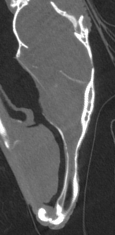

In [59]:
print(imlist[75].size)
imlist[75]

In [101]:
print(np.unique(masklist[75]))

[360 361 362 363]


In [79]:
print(seglist2[75])

[{'area': 25479, 'bbox': [0, 0, 115, 235], 'category_id': 0, 'id': 360}, {'area': 95, 'bbox': [38, 208, 9, 14], 'category_id': 1, 'id': 361}, {'area': 17, 'bbox': [47, 217, 5, 4], 'category_id': 2, 'id': 362}, {'area': 1434, 'bbox': [0, 0, 95, 225], 'category_id': 2, 'id': 363}]


In [102]:
datadict = {"image": imlist, "label": masklist, "segments_info": seglist2}

In [107]:
import datasets

ds = datasets.Dataset.from_dict(datadict)


In [64]:
print(ds[100]['label'])

<PIL.PngImagePlugin.PngImageFile image mode=L size=115x235 at 0x17DBE9DE6C8>


In [65]:
ds.save_to_disk("OneScanDataset.hf")

In [103]:
from transformers import Mask2FormerImageProcessor
import torch
processor = Mask2FormerImageProcessor(ignore_index=0, do_normalize=False, do_resize=False, do_rescale=False)

In [104]:
inst2class = {segment['id']: segment['category_id'] for segment in datadict['segments_info'][75]}
print(inst2class)

{360: 0, 361: 1, 362: 2, 363: 3}


In [105]:
print(np.stack([np.array(imlist[0]), np.array(imlist[0]), np.array(imlist[0])]).shape)
print(np.array(masklist[0]).shape)

(3, 235, 115)
(235, 115)


In [106]:

inputs = processor([np.stack([np.array(imlist[75], dtype=np.float32), np.array(imlist[75], dtype=np.float32), np.array(imlist[75], dtype=np.float32)])], [masklist[75]], instance_id_to_semantic_id=inst2class, return_tensors='pt')

In [107]:
print(inputs)

{'pixel_values': tensor([[[[10222., 10896., 11543.,  ...,  8807.,  9383., 11368.],
          [11119., 10885., 11058.,  ..., 10974.,  9454.,  9456.],
          [11516., 11707., 10921.,  ..., 12114., 11971., 11105.],
          ...,
          [10593.,  9851., 10610.,  ..., 10575.,  9681.,  9102.],
          [ 9962.,  9767.,  9859.,  ..., 10247.,  9551.,  9259.],
          [10771., 10236., 10308.,  ..., 10727.,  9662.,  9219.]],

         [[10222., 10896., 11543.,  ...,  8807.,  9383., 11368.],
          [11119., 10885., 11058.,  ..., 10974.,  9454.,  9456.],
          [11516., 11707., 10921.,  ..., 12114., 11971., 11105.],
          ...,
          [10593.,  9851., 10610.,  ..., 10575.,  9681.,  9102.],
          [ 9962.,  9767.,  9859.,  ..., 10247.,  9551.,  9259.],
          [10771., 10236., 10308.,  ..., 10727.,  9662.,  9219.]],

         [[10222., 10896., 11543.,  ...,  8807.,  9383., 11368.],
          [11119., 10885., 11058.,  ..., 10974.,  9454.,  9456.],
          [11516., 11707.

In [108]:
from transformers import Mask2FormerForUniversalSegmentation


category_info = {0: 'Background', 1: 'Lower Jaw', 2: 'Tooth', 3: 'Other Bone'}
model = Mask2FormerForUniversalSegmentation.from_pretrained('facebook/mask2former-swin-base-coco-panoptic', id2label=category_info, ignore_mismatched_sizes=True)

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-coco-panoptic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([134]) in the checkpoint and torch.Size([5]) in the model instantiated
- class_predictor.weight: found shape torch.Size([134, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([134]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [110]:
out = model(**inputs)
print(out.loss)

tensor([70.0449], grad_fn=<AddBackward0>)
